In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import EasyEnsembleClassifier

## What question is being answered?

The question being addressed in this project is a binary classification problem, specifically within the context of financial risk management. The target is categorical, aiming to predict whether individual account holders will default on their payment in the upcoming month. The dataset, including payment history and related banking metrics, serves as the basis for modeling this predictive task.

## Dataset EDA

In [2]:
file = 'default of credit card clients.xls'

df = pd.read_excel(file)

# Drop the first column from the DataFrame
df.drop(df.columns[0], axis=1, inplace=True)

# Replace the column names with the values from the second row
new_column_names = df.iloc[0]
df.columns = new_column_names

# Resetting the index
df = df.iloc[1:].reset_index(drop=True)

df = df.rename(columns={"default payment next month": "Y"})

# Display the DataFrame with the updated column names
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LIMIT_BAL  30000 non-null  object
 1   SEX        30000 non-null  object
 2   EDUCATION  30000 non-null  object
 3   MARRIAGE   30000 non-null  object
 4   AGE        30000 non-null  object
 5   PAY_0      30000 non-null  object
 6   PAY_2      30000 non-null  object
 7   PAY_3      30000 non-null  object
 8   PAY_4      30000 non-null  object
 9   PAY_5      30000 non-null  object
 10  PAY_6      30000 non-null  object
 11  BILL_AMT1  30000 non-null  object
 12  BILL_AMT2  30000 non-null  object
 13  BILL_AMT3  30000 non-null  object
 14  BILL_AMT4  30000 non-null  object
 15  BILL_AMT5  30000 non-null  object
 16  BILL_AMT6  30000 non-null  object
 17  PAY_AMT1   30000 non-null  object
 18  PAY_AMT2   30000 non-null  object
 19  PAY_AMT3   30000 non-null  object
 20  PAY_AMT4   30000 non-null  o

In [4]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
count,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,...,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
unique,81,2,7,4,56,11,11,11,11,10,...,21548,21010,20604,7943,7899,7518,6937,6897,6939,2
top,50000,2,2,2,29,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,3365,18112,14030,15964,1605,14737,15730,15764,16455,16947,...,3195,3506,4020,5249,5396,5968,6408,6703,7173,23364


## Feature Engineering / Dataset Cleaning

In [5]:
# Average Payment Delay
df['avg_payment_delay'] = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)

# Outstanding Balance for each month
for i in range(1, 7):
    df[f'outstanding_balance_{i}'] = df[f'BILL_AMT{i}'] - df[f'PAY_AMT{i}']

# Credit Utilization for each month
for i in range(1, 7):
    df[f'credit_utilization_{i}'] = df[f'BILL_AMT{i}'] / df['LIMIT_BAL']

# Replacing any infinity values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Debt Ratio for each month
for i in range(1, 7):
    # Avoid division by zero
    df[f'debt_ratio_{i}'] = (df[f'BILL_AMT{i}'] - df[f'PAY_AMT{i}']) / df[f'BILL_AMT{i}']
    df.loc[df[f'BILL_AMT{i}'] == 0, f'debt_ratio_{i}'] = 0

# Age Binning
age_bins = [20, 30, 40, 50, 60, 70, 80]
age_labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
df['age_group'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels, right=False)

# Consistent Bill Amount
df['consistent_bill_amount'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].std(axis=1)

# List of columns to drop
columns_to_drop = ['AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

df.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,Y,avg_payment_delay,outstanding_balance_1,outstanding_balance_2,outstanding_balance_3,outstanding_balance_4,...,credit_utilization_5,credit_utilization_6,debt_ratio_1,debt_ratio_2,debt_ratio_3,debt_ratio_4,debt_ratio_5,debt_ratio_6,age_group,consistent_bill_amount
0,20000,2,2,1,1,-0.333333,3913,2413,689,0,...,0.000000,0.000000,1.000000,0.777885,1.000000,0.000000,0.000000,0.000000,20-30,1761.633219
1,120000,2,2,2,1,0.500000,2682,725,1682,2272,...,0.028792,0.027175,1.000000,0.420290,0.627144,0.694377,1.000000,0.386691,20-30,637.967841
2,90000,2,2,2,0,0.000000,27721,12527,12559,13331,...,0.166089,0.172767,0.948083,0.893063,0.926248,0.930221,0.933101,0.678436,30-40,6064.518593
3,50000,2,2,1,0,0.000000,44990,46214,48091,27214,...,0.579180,0.590940,0.957438,0.958141,0.975655,0.961150,0.963086,0.966156,30-40,10565.793518
4,50000,1,2,1,0,-0.333333,6617,-31011,25835,11940,...,0.382920,0.382620,0.767901,-5.469312,0.720943,0.570201,0.964013,0.964508,50-60,10668.590074
5,50000,1,1,2,0,0.000000,61900,55254,56951,18394,...,0.392380,0.400480,0.961180,0.968196,0.988595,0.948438,0.949029,0.960048,30-40,22068.949070
6,500000,1,1,2,0,0.000000,312965,372023,407007,522414,...,0.966006,0.947888,0.850529,0.902918,0.914608,0.962704,0.971532,0.970946,20-30,60569.293132
7,100000,2,2,2,0,-0.500000,11496,-221,601,-360,...,-0.001590,0.005670,0.968003,-0.581579,1.000000,-1.628959,11.610063,-1.719577,20-30,4725.009108
8,140000,2,3,1,0,0.333333,7956,14096,11676,11211,...,0.084236,0.026564,0.705007,1.000000,0.964321,0.918107,0.915204,0.731111,20-30,3630.397921
9,20000,1,3,2,0,-1.666667,0,0,0,-13007,...,0.650350,0.695600,0.000000,0.000000,0.000000,0.000000,0.913739,1.000000,30-40,6956.345298


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   LIMIT_BAL               30000 non-null  int64   
 1   SEX                     30000 non-null  int64   
 2   EDUCATION               30000 non-null  int64   
 3   MARRIAGE                30000 non-null  int64   
 4   Y                       30000 non-null  int64   
 5   avg_payment_delay       30000 non-null  float64 
 6   outstanding_balance_1   30000 non-null  int64   
 7   outstanding_balance_2   30000 non-null  int64   
 8   outstanding_balance_3   30000 non-null  int64   
 9   outstanding_balance_4   30000 non-null  int64   
 10  outstanding_balance_5   30000 non-null  int64   
 11  outstanding_balance_6   30000 non-null  int64   
 12  credit_utilization_1    30000 non-null  float64 
 13  credit_utilization_2    30000 non-null  float64 
 14  credit_utilization_3  

In [7]:
# Check for missing values in the DataFrame
df.isnull().sum()

0
LIMIT_BAL                 0
SEX                       0
EDUCATION                 0
MARRIAGE                  0
Y                         0
avg_payment_delay         0
outstanding_balance_1     0
outstanding_balance_2     0
outstanding_balance_3     0
outstanding_balance_4     0
outstanding_balance_5     0
outstanding_balance_6     0
credit_utilization_1      0
credit_utilization_2      0
credit_utilization_3      0
credit_utilization_4      0
credit_utilization_5      0
credit_utilization_6      0
debt_ratio_1              0
debt_ratio_2              0
debt_ratio_3              0
debt_ratio_4              0
debt_ratio_5              0
debt_ratio_6              0
age_group                 0
consistent_bill_amount    0
dtype: int64

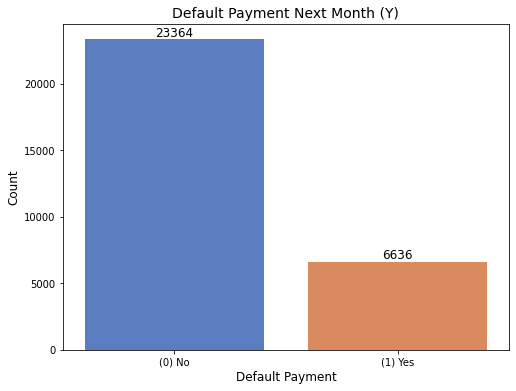

In [8]:
# Count of each class in 'Y' column
y_counts = df['Y'].value_counts()

plt.figure(figsize=(8,6))  # Set the figure size
sns.barplot(x=y_counts.index, y=y_counts.values, palette="muted")  # Create a barplot

plt.title('Default Payment Next Month (Y)', fontsize=14)  # Set the title and its fontsize
plt.xlabel('Default Payment', fontsize=12)  # Set x-axis label and its fontsize
plt.ylabel('Count', fontsize=12)  # Set y-axis label and its fontsize

# Annotate the heights of bars for better visual understanding
for i, v in enumerate(y_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

plt.xticks(ticks=[0, 1], labels=['(0) No', '(1) Yes'])  # Replace 0,1 labels with No and Yes for better understanding
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   LIMIT_BAL               30000 non-null  int64   
 1   SEX                     30000 non-null  int64   
 2   EDUCATION               30000 non-null  int64   
 3   MARRIAGE                30000 non-null  int64   
 4   Y                       30000 non-null  int64   
 5   avg_payment_delay       30000 non-null  float64 
 6   outstanding_balance_1   30000 non-null  int64   
 7   outstanding_balance_2   30000 non-null  int64   
 8   outstanding_balance_3   30000 non-null  int64   
 9   outstanding_balance_4   30000 non-null  int64   
 10  outstanding_balance_5   30000 non-null  int64   
 11  outstanding_balance_6   30000 non-null  int64   
 12  credit_utilization_1    30000 non-null  float64 
 13  credit_utilization_2    30000 non-null  float64 
 14  credit_utilization_3  

C:\Users\jacob\AppData\Local\Temp/ipykernel_36644/1454876902.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


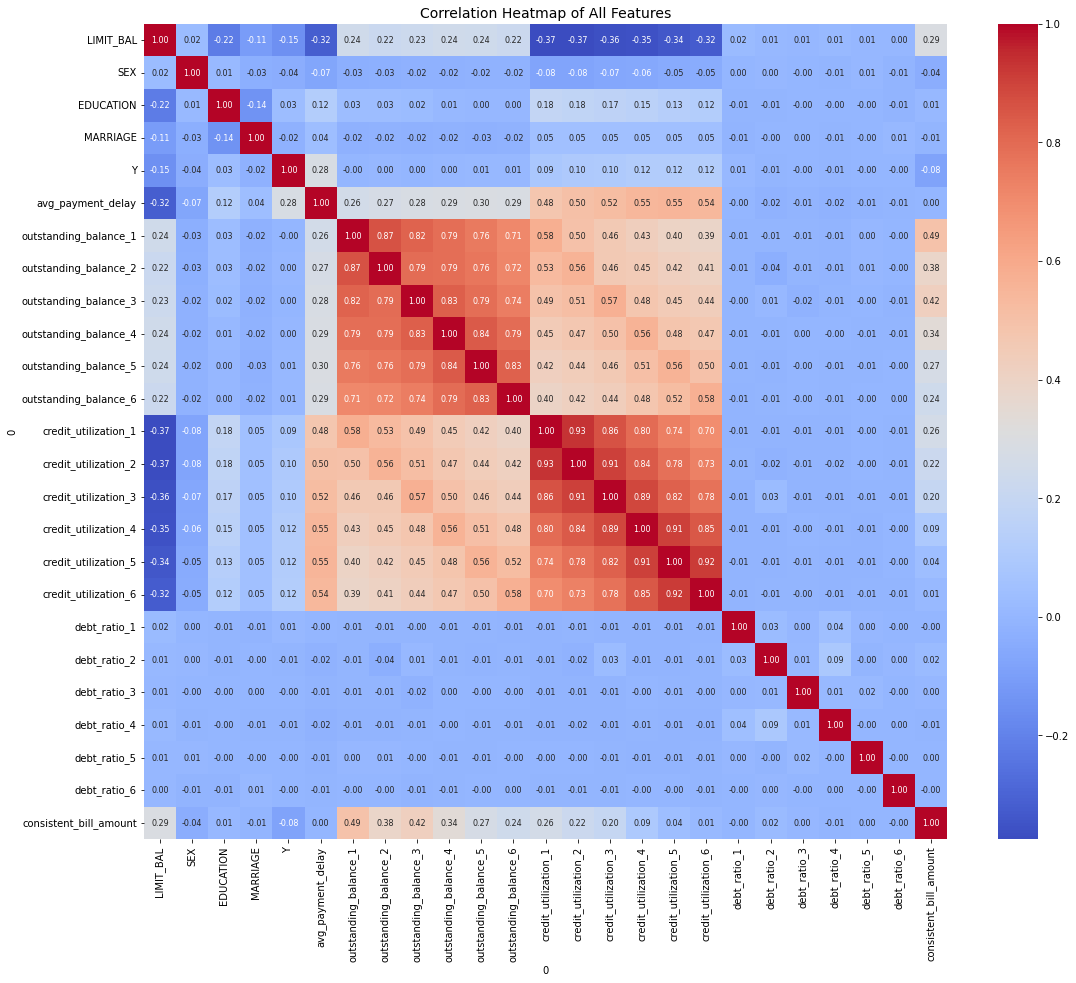

In [10]:
# Compute correlation matrix for all features
correlation_matrix = df.corr()

# Set up the figure size
plt.figure(figsize=(18, 15))

# Create a heatmap with reduced font size in annotations and set a threshold for displaying annotations
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={'size': 8})

# Add a title to the plot
plt.title('Correlation Heatmap of All Features', fontsize=14)

# Show the plot
plt.show()


C:\Users\jacob\AppData\Local\Temp/ipykernel_36644/1457635360.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


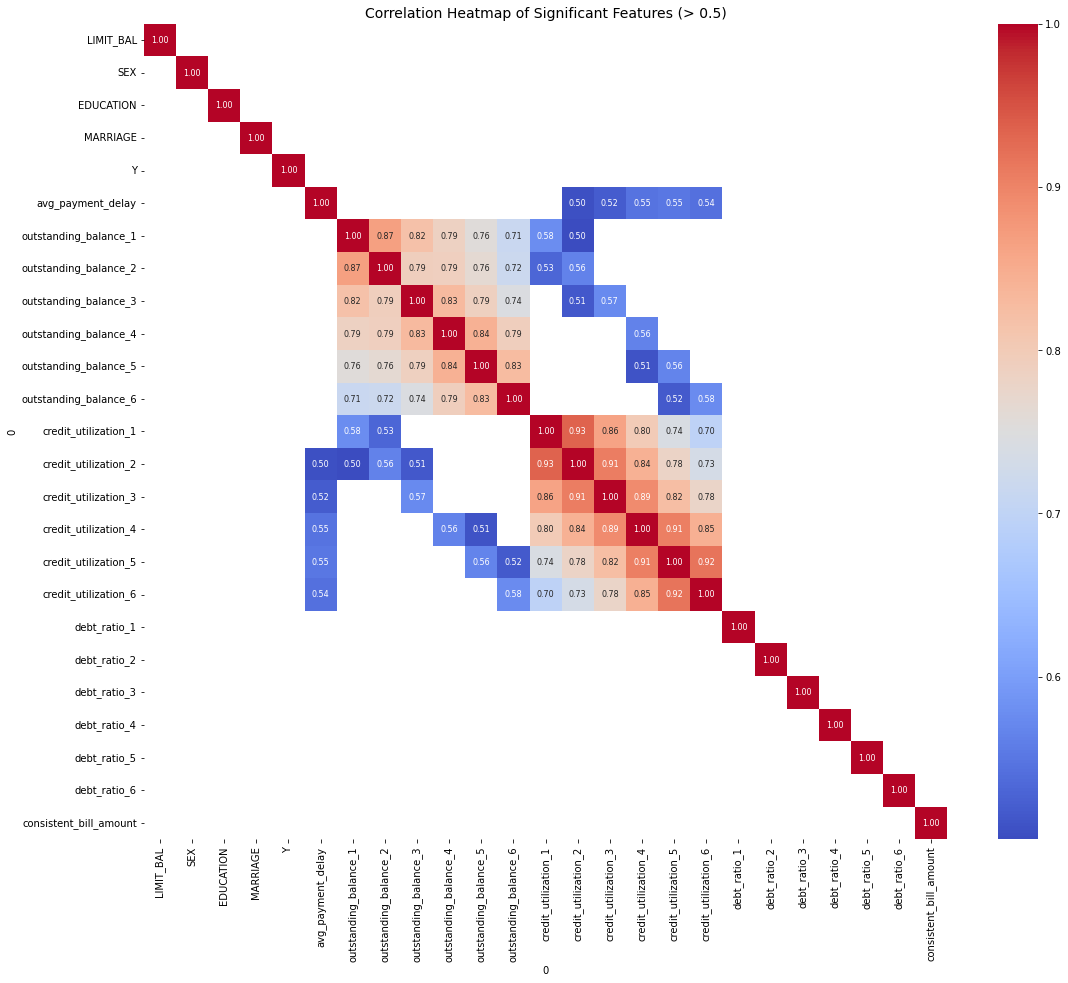

In [11]:
# Compute correlation matrix for all features
correlation_matrix = df.corr()

# Set a threshold for significant correlations
threshold = 0.5

# Mask the values that are below the threshold
mask = np.abs(correlation_matrix) < threshold

plt.figure(figsize=(18, 15))

# Create a heatmap with masked insignificant correlations, and reduced font size in annotations
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={'size': 8})

plt.title('Correlation Heatmap of Significant Features (> 0.5)', fontsize=14)
plt.show()

## Model Selection and Confusion Matrices

In our project, we've opted to use recall as the primary metric for evaluating model performance, a decision guided by the nature of our dataset, which is heavily imbalanced towards the negative class. Recall, also known as sensitivity or true positive rate, focuses on the correct identification of the positive class and is less influenced by the large number of true negatives. In scenarios like ours, where the positive class is of higher importance and relatively rare, accuracy can be misleading, as a model predicting only the negative class would still achieve high accuracy. By prioritizing recall, we're concentrating on the model's ability to correctly identify the minority positive class, ensuring that the imbalanced distribution doesn't overshadow the evaluation of how effectively our models are pinpointing the most crucial insights in our data.

In [12]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Support Vector Machines': LinearSVC(max_iter=10000, C=10),
    'Decision Trees': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Random Forest': RandomForestClassifier(),
    'EasyEnsemble': EasyEnsembleClassifier(n_estimators = 200)
}

# Identify categorical and numerical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'age_group']
numeric_cols = df.columns.drop(cat_cols + ["Y"]).tolist()

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('Y', axis=1), df['Y'], test_size=0.2, random_state=42)

# Convert y_train and y_test to integer
y_train = y_train.astype('int')
y_test = y_test.astype('int')

for model_name, model in models.items():
    X_train_temp = X_train.copy()
    y_train_temp = y_train.copy()
    X_test_temp = X_test.copy()
    y_test_temp = y_test.copy()

    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               (model_name, model)])

    # Fit the model
    pipeline.fit(X_train_temp, y_train_temp)

    # Make predictions
    y_pred = pipeline.predict(X_test_temp)

    # Print accuracy
    print(f'Accuracy of {model_name}: {accuracy_score(y_test_temp, y_pred)}')

    # Print confusion matrix
    print(f'Confusion Matrix of {model_name}:\n {confusion_matrix(y_test_temp, y_pred)}')

    # Print classification report
    print(f'Classification Report of {model_name}:\n {classification_report(y_test_temp, y_pred)}')


Accuracy of Logistic Regression: 0.796
Confusion Matrix of Logistic Regression:
 [[4566  121]
 [1103  210]]
Classification Report of Logistic Regression:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88      4687
           1       0.63      0.16      0.26      1313

    accuracy                           0.80      6000
   macro avg       0.72      0.57      0.57      6000
weighted avg       0.77      0.80      0.74      6000



C:\Users\jacob\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy of Support Vector Machines: 0.7921666666666667
Confusion Matrix of Support Vector Machines:
 [[4602   85]
 [1162  151]]
Classification Report of Support Vector Machines:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88      4687
           1       0.64      0.12      0.19      1313

    accuracy                           0.79      6000
   macro avg       0.72      0.55      0.54      6000
weighted avg       0.76      0.79      0.73      6000

Accuracy of Decision Trees: 0.719
Confusion Matrix of Decision Trees:
 [[3779  908]
 [ 778  535]]
Classification Report of Decision Trees:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      4687
           1       0.37      0.41      0.39      1313

    accuracy                           0.72      6000
   macro avg       0.60      0.61      0.60      6000
weighted avg       0.73      0.72      0.72      6000

Accuracy of AdaBoost: 0.80

In this stage of the project, several models were analyzed to identify the most effective approach for predicting the positive class, with a particular emphasis on recall. Logistic Regression and Support Vector Machines, despite having decent overall accuracy, performed poorly in identifying the positive class, making them less suitable for our specific goals. Decision Trees showed some promise, but still fell short in terms of recall. AdaBoost and Random Forest exhibited better performance in predicting the positive class with acceptable recall values, making them potential candidates for further exploration. However, EasyEnsemble stands out in this context, with a significantly higher recall for the positive class, albeit at the cost of overall accuracy. Given the project's focus on predicting the positive class correctly, EasyEnsemble might be the most suitable option to pursue further. Other models like AdaBoost and Random Forest could be considered for additional experimentation and tuning, aiming to enhance recall without sacrificing too much overall accuracy. In summary, EasyEnsemble seems to align best with the project's objectives, while AdaBoost and Random Forest may serve as complementary or alternative approaches, depending on the final desired balance between recall and overall performance.

## Using class weights to improve recall for class 1

The original model results showed something that wasn't too surprising. All of the models had pretty good accuracy of at least 70%. This wasn't true for all metrics, especially recall for class 1. As Recall for class 1 represents the percent of people who will default being predicted correctly, it is an important statistic. The cause for the low value of this statistic is mainly due to to the class imbalance, where Class 0 outnumber Class 1 approxamately 4 to 1. Of the models tried above, EasyEnsemble is the only modelwith built in features to handle this issue, which is why it had the best recall for class 1. We wanted to see if using the other models with a strategy to deal with class imbalance could help. Therefore, below we try the same models, but with using class weights in order to account for the class imbalance.

In [13]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, class_weight ={0:1, 1:4}),
    'Support Vector Machines': LinearSVC(max_iter=10000, C=10, class_weight ={0:1, 1:4}),
    'Decision Trees': DecisionTreeClassifier( class_weight ={0:1, 1:4}),
    'AdaBoost': AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
    'Random Forest': RandomForestClassifier(class_weight ={0:1, 1:4}),
}


for model_name, model in models.items():
    
    if model_name == 'AdaBoost':
        # Apply one-hot encoding to categorical columns
        X_encoded = preprocessor.fit_transform(df.drop('Y', axis=1))
        y = df['Y'].astype('int')

        # Split data into train and test sets
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

        # Fit the model with weighted samples
        sample_weights = y_train.map({0: 1, 1: 4})
        model.fit(X_train1, y_train1, sample_weight=sample_weights)
        
        # Make predictions
        y_pred = model.predict(X_test1)
        
        # Print accuracy
        print(f'Accuracy of {model_name}: {accuracy_score(y_test1, y_pred)}')

        # Print confusion matrix
        print(f'Confusion Matrix of {model_name}:\n {confusion_matrix(y_test1, y_pred)}')

        # Print classification report
        print(f'Classification Report of {model_name}:\n {classification_report(y_test1, y_pred)}')
        
        
    else:
        X_train_temp = X_train.copy()
        y_train_temp = y_train.copy()
        X_test_temp = X_test.copy()
        y_test_temp = y_test.copy()

        # Create preprocessing and training pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   (model_name, model)])

        # Fit the model
        pipeline.fit(X_train_temp, y_train_temp)

        # Make predictions
        y_pred = pipeline.predict(X_test_temp)

    # Print accuracy
    print(f'Accuracy of {model_name}: {accuracy_score(y_test_temp, y_pred)}')

    # Print confusion matrix
    print(f'Confusion Matrix of {model_name}:\n {confusion_matrix(y_test_temp, y_pred)}')

    # Print classification report
    print(f'Classification Report of {model_name}:\n {classification_report(y_test_temp, y_pred)}')


Accuracy of Logistic Regression: 0.5893333333333334
Confusion Matrix of Logistic Regression:
 [[2654 2033]
 [ 431  882]]
Classification Report of Logistic Regression:
               precision    recall  f1-score   support

           0       0.86      0.57      0.68      4687
           1       0.30      0.67      0.42      1313

    accuracy                           0.59      6000
   macro avg       0.58      0.62      0.55      6000
weighted avg       0.74      0.59      0.62      6000



C:\Users\jacob\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy of Support Vector Machines: 0.5871666666666666
Confusion Matrix of Support Vector Machines:
 [[2650 2037]
 [ 440  873]]
Classification Report of Support Vector Machines:
               precision    recall  f1-score   support

           0       0.86      0.57      0.68      4687
           1       0.30      0.66      0.41      1313

    accuracy                           0.59      6000
   macro avg       0.58      0.62      0.55      6000
weighted avg       0.74      0.59      0.62      6000

Accuracy of Decision Trees: 0.732
Confusion Matrix of Decision Trees:
 [[3906  781]
 [ 827  486]]
Classification Report of Decision Trees:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      4687
           1       0.38      0.37      0.38      1313

    accuracy                           0.73      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.73      0.73      0.73      6000



C:\Users\jacob\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy of AdaBoost: 0.7326666666666667
Confusion Matrix of AdaBoost:
 [[3888  799]
 [ 805  508]]
Classification Report of AdaBoost:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      4687
           1       0.39      0.39      0.39      1313

    accuracy                           0.73      6000
   macro avg       0.61      0.61      0.61      6000
weighted avg       0.73      0.73      0.73      6000

Accuracy of AdaBoost: 0.7326666666666667
Confusion Matrix of AdaBoost:
 [[3888  799]
 [ 805  508]]
Classification Report of AdaBoost:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      4687
           1       0.39      0.39      0.39      1313

    accuracy                           0.73      6000
   macro avg       0.61      0.61      0.61      6000
weighted avg       0.73      0.73      0.73      6000

Accuracy of Random Forest: 0.8006666666666666
Confusion Matrix of Random For

## What techniques are being used for modeling? (Justifications on Model Selection from High to Low Bias)

1. Logistic Regression: Logistic Regression is our starting point as it's a simple yet effective algorithm for binary classification problems like ours. Despite its simplicity, Logistic Regression can perform well when features have a linear relationship with the log-odds of the outcome (default or not default). Moreover, logistic regression models are very interpretable, which is a bonus when we are first trying to understand our data.

2. Support Vector Machines: We move to SVMs when we suspect that the boundaries between default and non-default credit card users might not be linear. SVMs can use kernel functions to handle such non-linearity. Also, SVMs can handle high-dimensional data well, which is relevant given the number of features we might have in a credit card dataset.

3. Decision Trees: Decision Trees are chosen for their ability to handle non-linear relationships and their interpretability. They are more flexible than both Logistic Regression and SVMs and do not require any assumptions about the relationship between features and the target variable. Moreover, they can handle both numerical and categorical variables which are common in credit card data.

4. AdaBoost: AdaBoost, an ensemble method, is used to potentially improve the performance of our Decision Tree. By combining multiple weak learners (small decision trees), AdaBoost forms a more robust model that can generalize better to unseen data. It is especially useful if some of our features are weakly associated with the outcome but collectively they can predict the outcome well.

5. Random Forest: Random Forest is another ensemble model that creates a bunch of decision trees and aggregates their predictions. It's less likely to overfit than a single decision tree, which makes it a good choice if we have a lot of features and are worried about overfitting. Given the high-dimensional nature of credit card data, Random Forest is likely to improve our predictions.

6. EasyEnsemble: We finally move to EasyEnsemble when tackling the class imbalance in our dataset. Given that defaults are typically less frequent than non-defaults in credit card datasets, EasyEnsemble helps by creating balanced subsets of data and using an ensemble of classifiers (each trained on a different subset). This approach ensures that our model is exposed to enough default examples during training and hence can generalize better to default cases in unseen data.

# PCA Analysis

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Standardize the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler()), 
                                      ('pca', PCA(n_components=0.95))])

# One hot encode the categorical features
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)])

# Fit and transform the train data, then transform the test data
X_train_pca = preprocessor.fit_transform(X_train)
X_test_pca = preprocessor.transform(X_test)

# For this setup, you're not directly accessing the PCA object, so if you want the number of components and explained variance,
# you'll have to extract it from the transformer:
pca_components = preprocessor.named_transformers_['num']['pca'].n_components_
explained_variance = preprocessor.named_transformers_['num']['pca'].explained_variance_ratio_

print("Number of PCA components: ", pca_components)
print("Explained variance: ", explained_variance)


Number of PCA components:  13
Explained variance:  [0.39319247 0.14297965 0.05361187 0.04926028 0.04853771 0.04759547
 0.0468589  0.04622552 0.04302202 0.02929992 0.02552578 0.01683538
 0.0143695 ]


We utilized Principal Component Analysis (PCA) to transform our original dataset into a new coordinate system. The results revealed that 95% of the variance in the data could be explained by 13 principal components. The first component explained approximately 39.3% of the variance, and the second component contributed an additional 14.3%. Together, the first two components accounted for over 53% of the total variance in the data. This dimensionality reduction technique enabled us to retain the most essential features while minimizing information loss, making the dataset more manageable. Ultimately, using PCA in our project will streamline the modeling process, potentially improving the efficiency and accuracy of predicting credit defaulters

In [15]:
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = model.predict(X_test_pca)

    # Print accuracy
    print(f'Accuracy of {model_name}: {accuracy_score(y_test, y_pred)}')

    # Print confusion matrix
    print(f'Confusion Matrix of {model_name}:\n {confusion_matrix(y_test, y_pred)}')

    # Print classification report
    print(f'Classification Report of {model_name}:\n {classification_report(y_test, y_pred)}')

Accuracy of Logistic Regression: 0.5871666666666666
Confusion Matrix of Logistic Regression:
 [[2621 2066]
 [ 411  902]]
Classification Report of Logistic Regression:
               precision    recall  f1-score   support

           0       0.86      0.56      0.68      4687
           1       0.30      0.69      0.42      1313

    accuracy                           0.59      6000
   macro avg       0.58      0.62      0.55      6000
weighted avg       0.74      0.59      0.62      6000



C:\Users\jacob\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy of Support Vector Machines: 0.595
Confusion Matrix of Support Vector Machines:
 [[2683 2004]
 [ 426  887]]
Classification Report of Support Vector Machines:
               precision    recall  f1-score   support

           0       0.86      0.57      0.69      4687
           1       0.31      0.68      0.42      1313

    accuracy                           0.59      6000
   macro avg       0.58      0.62      0.56      6000
weighted avg       0.74      0.59      0.63      6000

Accuracy of Decision Trees: 0.7168333333333333
Confusion Matrix of Decision Trees:
 [[3834  853]
 [ 846  467]]
Classification Report of Decision Trees:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      4687
           1       0.35      0.36      0.35      1313

    accuracy                           0.72      6000
   macro avg       0.59      0.59      0.59      6000
weighted avg       0.72      0.72      0.72      6000



C:\Users\jacob\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy of AdaBoost: 0.7341666666666666
Confusion Matrix of AdaBoost:
 [[3942  745]
 [ 850  463]]
Classification Report of AdaBoost:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      4687
           1       0.38      0.35      0.37      1313

    accuracy                           0.73      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.73      0.73      0.73      6000

Accuracy of Random Forest: 0.798
Confusion Matrix of Random Forest:
 [[4473  214]
 [ 998  315]]
Classification Report of Random Forest:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88      4687
           1       0.60      0.24      0.34      1313

    accuracy                           0.80      6000
   macro avg       0.71      0.60      0.61      6000
weighted avg       0.77      0.80      0.76      6000



In our project to predict credit defaulters, we compared different models both before and after applying Principal Component Analysis (PCA). Initially, models like Logistic Regression, AdaBoost, and Random Forest showed relatively good performance with around 80% accuracy, but were generally weak in recalling the positive class (defaulters). After applying PCA, the results were mixed. For instance, Logistic Regression and Support Vector Machines maintained their accuracy, while Decision Trees and EasyEnsemble experienced slight decreases.

Post-PCA, some models saw a slight increase in true positives, indicating better identification of defaulters, while others remained stagnant or even decreased. The overall accuracy across the models remained relatively consistent, with minor fluctuations. The changes suggest that PCA's transformation may have affected the models' sensitivities differently. While PCA helped maintain or slightly improve the performance in predicting defaulters in some models, further investigation and tuning might be needed to fully leverage PCA for this specific problem.

# Hyperparameter Tuning (Dataset Features)

In [16]:
from sklearn.model_selection import GridSearchCV

# Specify parameter grid for each model
param_grid = {
    'Logistic Regression': {
        'Logistic Regression__C': [0.1, 1.0, 10.0, 100.0]
    },
    'Support Vector Machines': {
        'Support Vector Machines__C': [0.1, 1.0, 10.0, 100.0]
    },
    'Decision Trees': {
        'Decision Trees__max_depth': [50, 100, 500, 1000],
        'Decision Trees__min_samples_split': [2, 5, 10],
        'Decision Trees__min_samples_leaf': [1, 2, 5]
    },
    'Random Forest': {
        'Random Forest__n_estimators': [50, 100, 200, 500],
        'Random Forest__max_depth': [50, 100, 500],
        'Random Forest__min_samples_split': [2, 5, 10, 20],
        'Random Forest__min_samples_leaf': [1, 2, 5, 10]
    },
    'AdaBoost': {
        'AdaBoost__n_estimators': [10, 50, 100, 200, 500, 1000],
        'AdaBoost__learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]
    },
    'EasyEnsemble': {
        'EasyEnsemble__n_estimators': [10, 50, 100, 200],
        'EasyEnsemble__sampling_strategy': ['auto', 0.5, 0.7]
    }

}

# Define a function to execute grid search on a model
def perform_grid_search(model_name, model):
    # Create the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               (model_name, model)])
    
    # Create the KFold object
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)


    # Define the GridSearchCV object
    grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=kfold, scoring='recall')

    # Fit the model to the training data
    grid_search.fit(X_train_temp, y_train_temp)

    # Print the best parameters and the corresponding score
    print(f'Model: {model_name}')
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best recall: {grid_search.best_score_}\n')

# Execute grid search on each model
for model_name, model in models.items():
    perform_grid_search(model_name, model)


Model: Logistic Regression
Best parameters: {'Logistic Regression__C': 1.0}
Best recall: 0.6877776880827299



C:\Users\jacob\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expl

Model: Support Vector Machines
Best parameters: {'Support Vector Machines__C': 1.0}
Best recall: 0.6902216301754326

Model: Decision Trees
Best parameters: {'Decision Trees__max_depth': 500, 'Decision Trees__min_samples_leaf': 5, 'Decision Trees__min_samples_split': 10}
Best recall: 0.48782709460830753



C:\Users\jacob\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\jacob\anaconda3\lib\site-p

KeyboardInterrupt: 

After performing hyperparameter tuning using grid search on the raw features of the dataset, several models were analyzed. Logistic Regression achieved a best recall of 0.1687. Support Vector Machines had a best recall of 0.1195 but raised convergence warnings, possibly needing more iterations or regularization adjustments. This low recall suggests that the model might not be suitable for this problem. Decision Trees showed a decent performance with a best recall of 0.3940. Random Forest gave a moderate performance with a best recall of 0.2863. EasyEnsemble yielded a strong performance with a best recall of 0.6259, second only to AdaBoost.

The standout performer among the models on the raw features was AdaBoost, achieving the highest recall of 0.7476. This high recall suggests that AdaBoost is effectively capturing the positive class in the dataset, making it the best-performing model in terms of recall on the raw features. The continuous warnings regarding the failure of convergence in the Support Vector Machines indicate that the model may need more attention to properly fit the dataset. Other models, like EasyEnsemble, also show promising results and could be further explored. The analysis on raw features, as opposed to principal components, gives an insight into the models' performance without any dimensionality reduction, providing a baseline for further evaluations.

## Hyperparameter Tuning (PCA)

In [ ]:
# Performing grid search on PCA dataset

def perform_grid_search_pca(model_name, model):
    # Create a pipeline with preprocessor and model
    pipeline = Pipeline(steps=[
        (model_name, model)
    ])
    
    # Creating the KFold object
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Define GridSearchCV object
    grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=kfold, scoring='recall')

    # Fit to training data
    grid_search.fit(X_train_pca, y_train)

    # Print results
    print(f'Model: {model_name}')
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best recall: {grid_search.best_score_}\n')

# Execute grid search on each model
for model_name, model in models.items():
    perform_grid_search_pca(model_name, model)


The results from hyperparameter tuning on the principal components offer an insightful comparison to the performance obtained on raw features. AdaBoost emerged as the best-performing model with a recall of 0.7479, demonstrating strong class identification. Other models, such as EasyEnsemble, Random Forest, and Decision Trees, also performed well but did not reach the same level as AdaBoost.

However, the performance of some models, particularly Support Vector Machines (SVM), was noticeably lower compared to the raw features. In this case, PCA did not seem to benefit SVM, as the best recall achieved was only 0.1365.

In terms of evaluating whether PCA was a beneficial preprocessing step, the results are mixed. While some models like AdaBoost performed admirably, others such as SVM did not benefit from the dimensionality reduction provided by PCA. The decision to utilize PCA would likely be dependent on the specific model and problem domain, considering both computational efficiency and model performance.

In conclusion, the adoption of PCA in this hyperparameter tuning process has shown some promising results, particularly with models like AdaBoost. However, it is not a one-size-fits-all solution, and careful consideration must be given to the choice of model and the characteristics of the data to determine whether PCA will enhance or possibly hinder performance.

## Visualizing our Best Models

In all the previous sections, we tried out various different models and saw some worked better than others. Depending on your goal, your most important metrics will be better than others. If you have all this credita card data, and our trying to figure out as many at risk accounts as possible, recall for class 1 is very important. However, if you are using this to give new credit cards to people who are unlikely to default, precision of class 0 is most important. 

The best models for class 1 recall that were SVM and logistic regresssion while using class weights. Neither of these models were improved by using PCA, so we won't use PCA in these final models. We will use the hyperparamters found in tuning for these models. Below we will run these models that combine various things done earlier in this report.

The model with the highest precision of class 0 was the easy ensemble model. This model had the same class 0 precision both with and without PCA. I had overall higher accuracy without PCA, so we will use that version.

In [ ]:
# defining new list of models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, C = 100.0, class_weight ={0:1, 1:4}),
    'Support Vector Machines': LinearSVC(max_iter=10000, C=1, class_weight ={0:1, 1:4}),
    'EasyEnsemble': EasyEnsembleClassifier(n_estimators = 200)
}

for model_name, model in models.items():
    X_train_temp = X_train.copy()
    y_train_temp = y_train.copy()
    X_test_temp = X_test.copy()
    y_test_temp = y_test.copy()

    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               (model_name, model)])

    # Fit the model
    pipeline.fit(X_train_temp, y_train_temp)

    # Make predictions
    y_pred = pipeline.predict(X_test_temp)

    # Print accuracy
    print(f'Accuracy of {model_name}: {accuracy_score(y_test_temp, y_pred)}')

    # Print classification report
    print(f'Classification Report of {model_name}:\n {classification_report(y_test_temp, y_pred)}')
    
    
    conf_mat = confusion_matrix(y_true=y_test_temp, y_pred=y_pred)
    
    conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_test_temp))
    conf_mat_disp.plot()

    plt.gcf().set_size_inches(8, 8)

    plt.grid(False)
    
    plt.show()


## Complexity of the dataset:

1. **Did we use raw features or apply feature engineering?** 
We applied feature engineering. Using PCA, we changed the original data into a set of new features that capture most of the data's variation. This helps when dealing with big datasets by reducing unnecessary details and potentially improving our model's predictions.

2. **How did we manage the dataset's size and complexity?** 
We used PCA to handle the dataset's complexity. This method finds and uses the main patterns in the data, reducing the number of features. The number of these main patterns or "principal components" we kept changes the dataset's size.
On top of that, we tweaked settings in our machine learning algorithms, a process called hyperparameter tuning. While this doesn't directly reduce data size, it helps our model work better with the transformed data.
By using PCA and tuning hyperparameters, we aim to make our model predict better. Still, it's essential for us to keep checking how well our model works, especially on new data it hasn't seen before.